![](https://camo.githubusercontent.com/d440ac2eee1cb3ea33340a2c5f6f15a0878e9275/687474703a2f2f692e7974696d672e636f6d2f76692f3051493378675875422d512f687164656661756c742e6a7067)

Hey, hope you are doing well and fine.

In this notebook, we will be adding both the MNIST and Alphabets dataset and train a model on them together. So, for this classification, we will have 36 classes in total, 10 for digits and 26 for alphabets.

We will be using Keras API in this notebook.

I will try to keep it simple and beginner friendly, if you have any suggestions regarding improving the notebook, please leave a comment at the end of it. If you like the work, do appreciate in the way you like! :)

So, now, without telling more about what to come in this notebook, let's just dive right into it.

## Importing essential libraries

In [ ]:
import pandas as pd
import numpy as np
import os

from sklearn.model_selection import train_test_split
from sklearn import metrics

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(style = "darkgrid")

import gc

import keras
from keras.utils.np_utils import to_categorical
from keras import backend as K
from keras.models import Sequential
from keras.layers import Dense, Flatten, Dropout, MaxPool2D, Conv2D
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from keras.optimizers import Adam
from keras.layers.normalization import BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from keras.models import load_model

import tensorflow as tf

import warnings
warnings.filterwarnings("ignore")

import cv2

## Reading and Understanding data files

> We will be adding 10 to the target values of alphabet data, because 0-9 are already booked for digits and we don't want our model to confuse itself between "A" and "0" or "B" and "1" and so on, we will start the labels for alphabet targets from 10, so now, 0-9 will be digits and 10-35 will be alphabets.

In [ ]:
df_num = pd.read_csv("../input/train-digit-recognition-mnist/mnist_train.csv")
df_alph = pd.read_csv("../input/az-handwritten-alphabets-in-csv-format/A_Z Handwritten Data/A_Z Handwritten Data.csv")
df_alph["0"] += 10

> Shape of both dataframes.

In [ ]:
df_num.shape, df_alph.shape

((59999, 785), (372450, 785))

> So we can see that we have 60000 samples for numerals and 3,72,450 samples for alphabets.

> Let's now see some of the data samples.

In [ ]:
df_num.head(3)

,5,0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,...,0.608,0.609,0.610,0.611,0.612,0.613,0.614,0.615,0.616,0.617
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
df_alph.head(3)

,0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,...,0.639,0.640,0.641,0.642,0.643,0.644,0.645,0.646,0.647,0.648
0,10,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,10,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,10,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


> Let's now change the column names and both the data and make them same so that joining them will be much easy.

> What we are doing here is making column name as follows:
> - Target -> Label
> - Pixel value x -> pixel_x

In [ ]:
pixel_array = ["Label"]
for i in range(1, 785):
    pixel_array.append(f"pixel_{i}")
df_num.columns = pixel_array
df_alph.columns = pixel_array
del pixel_array
gc.collect()

33

> Since both of our dataframes have same name for both the columns, we can now simply concat them!

In [ ]:
df = pd.concat([df_num, df_alph], axis = 0)
df.shape

(432449, 785)

> Let's set the value for seed too, so that reproducing the same work would be possible.

In [ ]:
SEED = 42
np.random.seed(SEED)

## Little Bit of Data Analysis

> Now, let'see the distribution of data over all the classes.

Text(0.5, 1.0, 'Target value distribution')

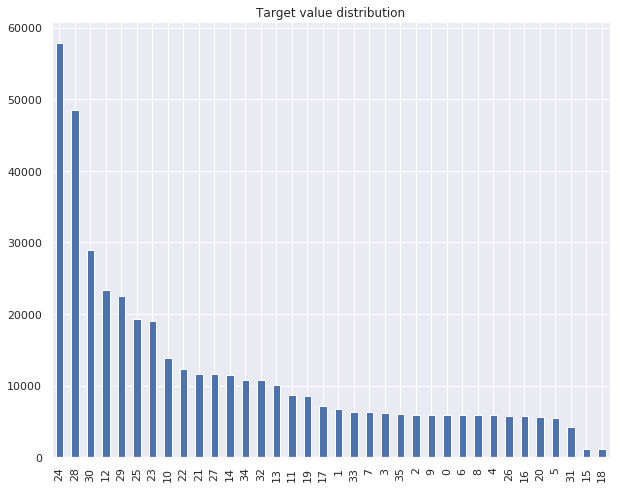

In [ ]:
plt.rcParams["figure.figsize"] = [10, 8]
df.Label.value_counts().plot(kind = "bar")
plt.title("Target value distribution")

> Although the MNIST data is all perfectly balanced, the other data i.e. Alphabetical data is very highly unbalanced.

> Let's now see the count of maximum and minimum frequency labels.

In [ ]:
a, b = df.Label[df.Label == 24].value_counts().sum(), df.Label[df.Label == 18].value_counts().sum()
print(f"Maximum and Minimum frequency for any target value in the data: {a, b}")

Maximum and Minimum frequency for any target value in the data: (57825, 1120)


> 57,825 for the majority class and 1120 for minority!!

> Since the data is now unbalanced, we will have to choose our metric wisely, otherwise, we may get fooled by the accuracy, although we will keep an eye out for accuracy too! ;)

> Now let's divide the data into features and target.

In [ ]:
X = df.drop(["Label"], axis = 1)
y = df["Label"]
X.shape

(432449, 784)

> Till now, the data we had was 1-Dimensional, i.e. a 28x28 picture was flattened into 784 pixels.

> Let's now reshape our data into 28x28 images!

### Reshaping the data

In [ ]:
X_reshaped = X.values.astype("float32").reshape(X.shape[0], 28, 28)
y_int = y.values.astype("int32")
print(X.shape, "***", X_reshaped.shape)

(432449, 784) *** (432449, 28, 28)


> Let's now split the data into train and test data with a ratio of 7:3 and stratifying the target class.

> What stratifying will do is it will maintain the ratio of unique target values in train and test set same.

In [ ]:
X_reshaped = X_reshaped.reshape(-1, 28, 28, 1)

X_train, X_test, y_train, y_test = train_test_split(X_reshaped, y_int, test_size = 0.3, stratify = y)

data_to_predict = X_test.reshape(-1, 28, 28)

> Let's define a function to plot some of the images in a grid with their respective labels.

> We will be plotting the images with **gray** cmap, you can try a lot of different too, I would recommend taking a look at "inferno".

In [ ]:
def plot_grid(pred = False):
    fig=plt.figure(figsize=(8, 8))
    columns = 3
    rows = 3
    for i in range(1, columns*rows +1):
        index = np.random.randint(data_to_predict.shape[0])
        fig.add_subplot(rows, columns, i)
        plt.imshow(data_to_predict[index], cmap = plt.get_cmap("gray"))
        plt.xticks([])
        plt.yticks([])
        plt.xlabel(f"Label: {y_test[index]}")
    plt.tight_layout()
    plt.show()

> Let's now take some of the images from the data!

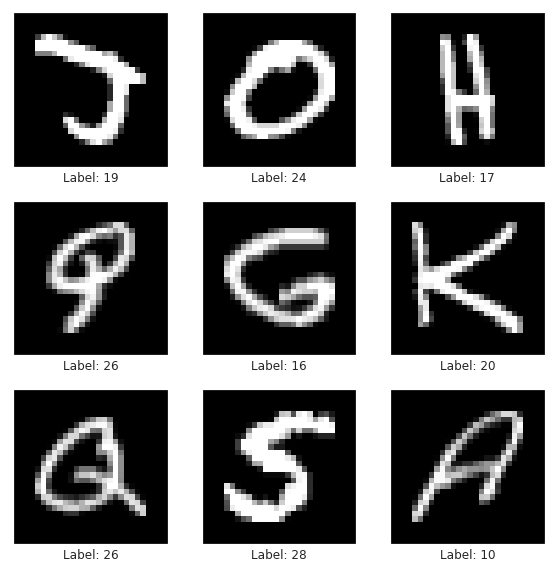

In [ ]:
plot_grid()

> They are a bit blurry but that's because of the low quality and figure size set by us too! Although they are very much recognizable.

> Standardization of Training data with categorization training and test data.

In [ ]:
X_train_mean = X_train.mean().astype(np.float32)
X_train_std = X_train.std().astype(np.float32)
X_test_mean = X_test.mean().astype(np.float32)
X_test_std = X_test.std().astype(np.float32)

X_train = (X_train - X_train_mean)/X_train_std
X_test = (X_test - X_test_mean)/X_test_std

y_train = to_categorical(y_train, num_classes = 36)
y_test = to_categorical(y_test, num_classes = 36)

In [ ]:
del X_train_mean, X_train_std, df_num, df_alph, X_reshaped, y_int, X, y, X_test_mean, X_test_std, data_to_predict, a, b
gc.collect()

10844

## Defining the Model

> Creating a simple CNN Classifier.

> We will be using two blocks of [Conv2D -> Conv2d -> MaxPool2D -> Dropout] one after the another and then a [Flatten -> Dense -> Dropout -> Dense]. That's it.

In [ ]:
# create CNN model for layers
input_shape = (28, 28, 1)
num_classes = 36

model = Sequential()
model.add(Conv2D(64, kernel_size = (3, 3), activation = "relu", padding = "Same", input_shape = input_shape))
model.add(Conv2D(64, kernel_size = (3, 3), activation = "relu", padding = "Same"))
model.add(MaxPool2D(pool_size = (3, 3)))
model.add(Dropout(0.25))

model.add(Conv2D(128, kernel_size = (3, 3), activation = "relu", padding = "Same"))
model.add(Conv2D(128, kernel_size = (3, 3), activation = "relu", padding = "Same"))
model.add(MaxPool2D(pool_size = (3, 3)))
model.add(Dropout(0.40))

model.add(Flatten())
model.add(Dense(150, activation = "relu"))
model.add(Dropout(0.30))
model.add(Dense(36, activation = "softmax"))
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 28, 28, 64)        640       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 9, 9, 64)          0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 9, 9, 64)          0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 9, 9, 128)         73856     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 9, 9, 128)         147584    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 3, 3, 128)        

> Defining **Adam** optimizer with a learning rate of 5e-4 and no decay.

In [ ]:
optimizer = Adam(lr = .0005, beta_1 = .9, beta_2 = .999, epsilon = 1e-07, decay = 0, amsgrad = False)

**Compiling model** and defining **learning rate reduction** parameters

In [ ]:
# Compile the model
model.compile(optimizer = optimizer, loss = "categorical_crossentropy", metrics = ["categorical_accuracy", tf.keras.metrics.AUC()])

# learning rate annealer
learning_rate_reduction = ReduceLROnPlateau(monitor = 'val_acc', patience = 3, verbose = 1, factor = .5, min_lr = .00001)

# EarlyStopping
es = EarlyStopping(monitor='val_categorical_accuracy', patience = 4)

> We will train this now for 80 epochs, since previously, when we trained it for 40 epochs, it was still converging, so increasing the number of epochs may get us better results.

> Also, we will be using a 128 batch size for this training, i.e. 128 images will the model be trained  upon at a time.

In [ ]:
epochs = 80
batch_size = 128

> Data Augmentation

> In data augmentation, we are going to do some modifications on the images like rotation, zoom, width shift, height shift and horizontal flip. Also, one must note that doing a vertical flip may be disastrous in some cases, for example, 6 will become 9 and vice versa.

In [ ]:
# Data Augmentation
datagen = ImageDataGenerator(featurewise_center = False, samplewise_center = False, 
                            featurewise_std_normalization = False, samplewise_std_normalization = False,
                            zca_whitening = False, rotation_range = 10, zoom_range = .1, 
                            width_shift_range = .1, height_shift_range = .1, horizontal_flip = True, 
                            vertical_flip = False)
train_batches = datagen.flow(X_train, y_train, batch_size = batch_size)
val_batches = datagen.flow(X_test, y_test, batch_size = batch_size)

## Training + Cross Validation

In [ ]:
# Fitting the model
history = model.fit_generator(generator = train_batches, steps_per_epoch = train_batches.n//batch_size, epochs=epochs, 
                    validation_data = val_batches, validation_steps = val_batches.n//batch_size, verbose = 0,
                    callbacks = [learning_rate_reduction, es])

> Let's now Save the model for future use.

In [ ]:
model.save("model_0-10_a-z.h5")

## Analysing trends in Accuracy and AUC

Let's see the number of epochs our model run for.

In [ ]:
print(f"Total number of epochs for which the model trained: {len(history.history['loss'])}")

Total number of epochs for which the model trained: 33


> Why not just plot the training and validation accuracy against each other, it will help us gain a lot of information about the training, like where our model stops learning, starts overfitting etc.

Text(0, 0.5, 'Accuracy')

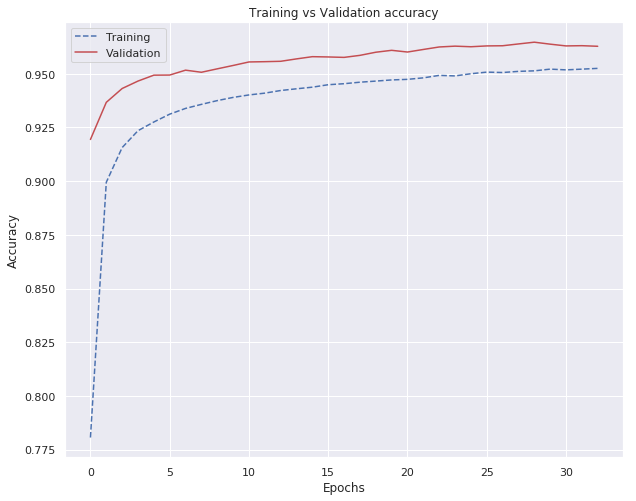

In [ ]:
plt.rcParams['figure.figsize'] = [10, 8]
plt.plot(history.history['categorical_accuracy'], "b--")
plt.plot(history.history['val_categorical_accuracy'], "r-")
plt.title("Training vs Validation accuracy")
plt.legend(["Training", "Validation"])
plt.xlabel("Epochs")
plt.ylabel("Accuracy")

In [ ]:
print(f"Maximum Training Accuracy: {max(history.history['categorical_accuracy'])}, Maximum Validation Accuracy: {max(history.history['val_categorical_accuracy'])}")

Maximum Training Accuracy: 0.9525192975997925, Maximum Validation Accuracy: 0.964708685874939


> Also, let's plot AUC scores for training and validation too!

Text(0, 0.5, 'AUC score')

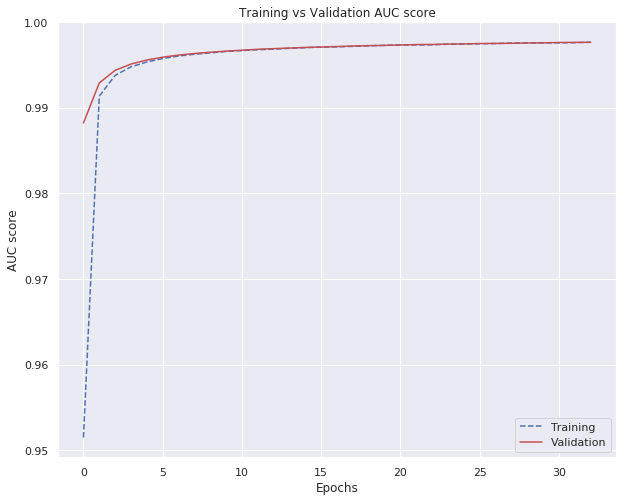

In [ ]:
plt.rcParams['figure.figsize'] = [10, 8]
plt.plot(history.history['auc'], "b--")
plt.plot(history.history['val_auc'], "r-")
plt.title("Training vs Validation AUC score")
plt.legend(["Training", "Validation"])
plt.xlabel("Epochs")
plt.ylabel("AUC score")

In [ ]:
print(f"Maximum Training AUC: {max(history.history['auc'])}, Maximum Validation AUC: {max(history.history['val_auc'])}")

Maximum Training AUC: 0.9976378083229065, Maximum Validation AUC: 0.997622549533844


Let's now the see the loss curve for both training and validation!

Text(0, 0.5, 'Loss value')

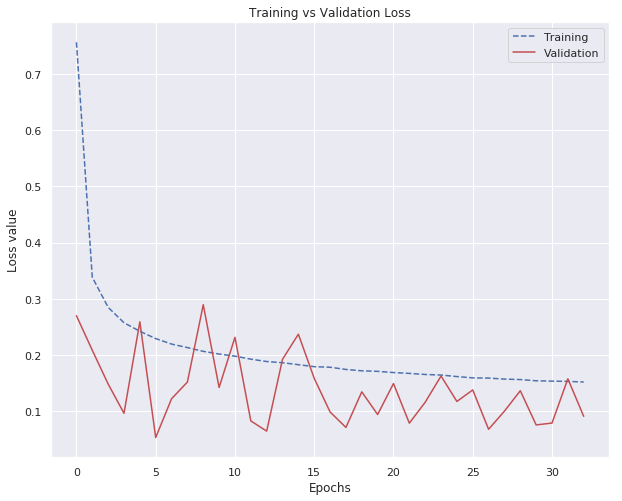

In [ ]:
plt.rcParams['figure.figsize'] = [10, 8]
plt.plot(history.history['loss'], "b--")
plt.plot(history.history['val_loss'], "r-")
plt.title("Training vs Validation Loss")
plt.legend(["Training", "Validation"])
plt.xlabel("Epochs")
plt.ylabel("Loss value")

> Woah, You reached the end of it!

> Hope you find reading this work worrthwhile. Please share your thoughts in the comment.

> Thanks for reading and Until next time! :)